In [2]:
# Step 1: Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from math import sqrt


In [5]:
# Step 2: Load Datasets
ratings_url = "https://files.grouplens.org/datasets/movielens/ml-100k/u.data"
movies_url = "https://files.grouplens.org/datasets/movielens/ml-100k/u.item"

ratings_cols = ["user_id", "movie_id", "rating", "timestamp"]
ratings = pd.read_csv(ratings_url, sep="\t", names=ratings_cols, encoding="latin-1")

movies_cols = ["movie_id", "title", "release_date", "video_release_date", "IMDb_URL",
               "unknown", "Action", "Adventure", "Animation", "Children's", "Comedy",
               "Crime", "Documentary", "Drama", "Fantasy", "Film-Noir", "Horror",
               "Musical", "Mystery", "Romance", "Sci-Fi", "Thriller", "War", "Western"]
movies = pd.read_csv(movies_url, sep="|", names=movies_cols, encoding="latin-1")

In [6]:
data = pd.merge(ratings, movies[["movie_id", "title"]], on="movie_id")

print("Dataset Loaded Successfully")
print(f"Total Ratings: {len(data)} | Users: {data.user_id.nunique()} | Movies: {data.movie_id.nunique()}")


Dataset Loaded Successfully
Total Ratings: 100000 | Users: 943 | Movies: 1682


/tmp/ipython-input-3972394062.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="rating", data=data, palette="Blues")


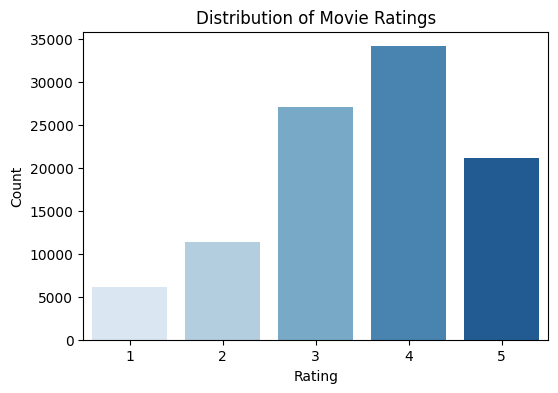

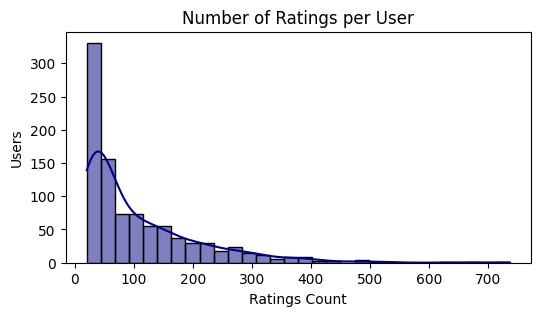

In [7]:
plt.figure(figsize=(6,4))
sns.countplot(x="rating", data=data, palette="Blues")
plt.title("Distribution of Movie Ratings")
plt.xlabel("Rating")
plt.ylabel("Count")
plt.show()

user_ratings_count = data.groupby("user_id").size()
plt.figure(figsize=(6,3))
sns.histplot(user_ratings_count, bins=30, kde=True, color='navy')
plt.title("Number of Ratings per User")
plt.xlabel("Ratings Count")
plt.ylabel("Users")
plt.show()

In [8]:
# Step 4: Create User–Movie Matrix
user_movie_matrix = data.pivot_table(index='user_id', columns='title', values='rating')
print(f"\nUser–Movie Matrix Shape: {user_movie_matrix.shape}")



User–Movie Matrix Shape: (943, 1664)


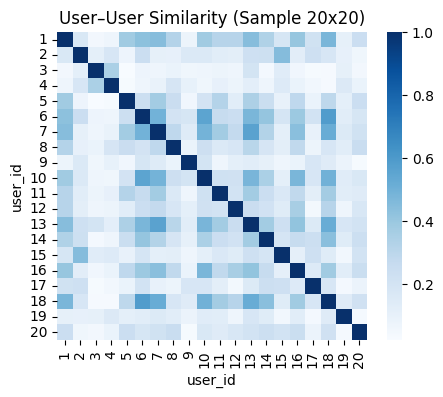

In [9]:
#Step 5: Compute User–User Similarity
user_similarity = cosine_similarity(user_movie_matrix.fillna(0))
user_similarity_df = pd.DataFrame(user_similarity,
                                  index=user_movie_matrix.index,
                                  columns=user_movie_matrix.index)

plt.figure(figsize=(5,4))
sns.heatmap(user_similarity_df.iloc[:20, :20], cmap='Blues')
plt.title("User–User Similarity (Sample 20x20)")
plt.show()

In [10]:
# Step 6: Function to Recommend Movies
def recommend_movies(user_id, n_recommendations=5):
    if user_id not in user_movie_matrix.index:
        print("User not found in dataset.")
        return []

    # Get similarity scores
    sim_scores = user_similarity_df[user_id].sort_values(ascending=False)
    sim_scores = sim_scores.drop(user_id)  # drop self-similarity

    top_users = sim_scores.head(10).index

    # Ratings from top similar users
    similar_users_ratings = user_movie_matrix.loc[top_users]

    # Weighted average
    weighted_ratings = similar_users_ratings.T.dot(sim_scores[top_users]) / sim_scores[top_users].sum()

    # Movies the user has already rated
    user_rated = user_movie_matrix.loc[user_id][user_movie_matrix.loc[user_id].notna()].index

    # Exclude rated movies
    recommendations = weighted_ratings.drop(user_rated, errors='ignore').sort_values(ascending=False)

    top_movies = recommendations.head(n_recommendations).index.tolist()

    return top_movies

In [11]:
#Step 7: Generate Recommendations for a Sample User
user_to_recommend = 15
recommended_movies = recommend_movies(user_to_recommend, n_recommendations=10)

print(f"\nTop 10 Recommended Movies for User {user_to_recommend}:\n")
for idx, movie in enumerate(recommended_movies, start=1):
    print(f"{idx}. {movie}")



Top 10 Recommended Movies for User 15:

1. Fargo (1996)
2. 'Til There Was You (1997)
3. 1-900 (1994)
4. 12 Angry Men (1957)
5. 187 (1997)
6. 2 Days in the Valley (1996)
7. 20,000 Leagues Under the Sea (1954)
8. 2001: A Space Odyssey (1968)
9. 3 Ninjas: High Noon At Mega Mountain (1998)
10. 39 Steps, The (1935)


In [16]:
global_mean = data["rating"].mean()
train, test = train_test_split(data, test_size=0.2, random_state=42)
train_matrix = train.pivot_table(index='user_id', columns='title', values='rating')
test_matrix = test.pivot_table(index='user_id', columns='title', values='rating')

# Recompute similarities on training set
train_similarity = cosine_similarity(train_matrix.fillna(0))
train_similarity_df = pd.DataFrame(train_similarity,
                                   index=train_matrix.index,
                                   columns=train_matrix.index)

def predict_rating(user_id, movie_title):
    if user_id not in train_matrix.index or movie_title not in train_matrix.columns:
        return np.nan

    sim_scores = train_similarity_df[user_id]
    ratings = train_matrix[movie_title]

    # Keep users who rated this movie
    valid_idx = ratings[ratings.notna()].index
    if len(valid_idx) == 0:
        return np.nan

    sims = sim_scores[valid_idx]
    weighted_sum = np.dot(sims, ratings[valid_idx])
    norm_factor = sims.abs().sum()
    if norm_factor == 0:
        return np.nan
    return weighted_sum / norm_factor

# Evaluate RMSE
y_true, y_pred = [], []
for _, row in test.iterrows():
    pred = predict_rating(row["user_id"], row["title"])
    if np.isnan(pred):
        pred = global_mean
    y_true.append(row["rating"])
    y_pred.append(pred)

rmse = sqrt(mean_squared_error(y_true, y_pred))
print(f"\nRMSE (User–User CF): {rmse:.3f}")



RMSE (User–User CF): 1.015
